<a href="https://colab.research.google.com/github/bigairboy/Stat-6289/blob/main/Stat_6289_Midterm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf


# read in data
data = pd.read_csv("//content/drive/MyDrive/fer2013.csv")

# split data
train = data[data.Usage == 'Training']
val = data[data.Usage == 'PublicTest']
test = data[data.Usage == 'PrivateTest']

# Change Y to one hot encoding  
def convert_emotion_to_one_hot(data):

    y = data["emotion"].values.ravel()    # flatten y
    num_classes = np.unique(y).shape[0]
    num_y = y.shape[0]
    index_offset = np.arange(num_y) * num_classes
    labels_one_hot = np.zeros((num_y, num_classes))
    labels_one_hot.flat[[index_offset + y.ravel()]] = 1

    return labels_one_hot

# Labels for classes
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# create output data
y_train = convert_emotion_to_one_hot(train)
y_val = convert_emotion_to_one_hot(val)
y_test = convert_emotion_to_one_hot(test)

# number of classes in output
y = data["emotion"].values.ravel()    # flatten y
num_classes = np.unique(y).shape[0]

# change X to workable data
def convert_pixels_to_images(data, image_size):

  pixels_values = data.pixels.str.split(" ").tolist()
  pixels_values = pd.DataFrame(pixels_values, dtype=int)

  images = pixels_values.values
  images = images.astype(np.float)
  images = images.reshape(images.shape[0], image_size, image_size, 1)
  images = images.astype('float32')

  return images

# create input data
image_size = 48
X_train = convert_pixels_to_images(train, image_size=image_size)     #images are 48*48
X_val = convert_pixels_to_images(val, image_size=image_size)         #images are 48*48
X_test = convert_pixels_to_images(test, image_size=image_size)       #images are 48*48



"""DATA AUGMENTATION (TRAINING DATA)"""

# select 200 random training images for augmentation
num_rand = 200
np.random.seed(42)
rand = list(np.random.randint(0, len(X_train), num_rand))
images_aug = X_train[rand]

# create augmentation function
def augment(image):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, image_size + 6, image_size + 6) # Add 6 pixels of padding
  image = tf.image.random_crop(image,size=[image_size, image_size, 1])             
  image = tf.image.random_flip_left_right(image)
  return image

# augment randomly selected training images images
for image in range(len(images_aug)):
  images_aug[image] = augment(images_aug[image])

# combine augmented data with training data
X_train = np.vstack((X_train, images_aug))
y_train = np.vstack((y_train, y_train[rand]))


"""DATA NORMALIZATION"""

X_train /= 255
X_val /= 255
X_test /= 255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, o

In [4]:
df = pd.concat([data.emotion.value_counts(), data.emotion.value_counts(normalize=True)], axis = 1)
df.columns = ['Number of Observations','Percentage']
df
#0 = "Angry" 1 =  "Disgust" 2 =  "Fear" 3 ="Happy" 4 = "Sad" 5 = "Surprise" 6 = "Neutral"

,Number of Observations,Percentage
3,8989,0.250481
6,6198,0.172709
4,6077,0.169337
2,5121,0.142698
0,4953,0.138017
5,4002,0.111517
1,547,0.015242


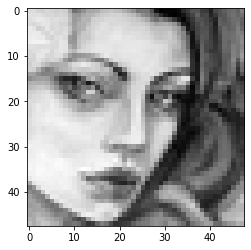

In [5]:
import matplotlib.pyplot as plt

example = X_val[7, :]
example = example.reshape(48, 48)
plt.imshow(example,cmap='gray')
plt.show()

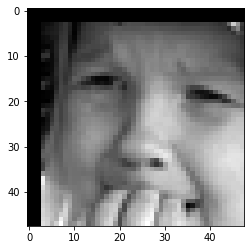

In [6]:
import matplotlib.pyplot as plt

example = images_aug[14, :]
example = example.reshape(48, 48)
plt.imshow(example,cmap='gray')
plt.show()

In [19]:
#Simplier VGG19 

from tensorflow.keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (48,48,1)))
model.add(layers.Conv2D(64, (3, 3), padding = "same",activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding = "same",activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding = "same",activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=5e-5, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])
vgg_model2 = model.fit(X_train,y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


904/904 [==============================] - 1273s 1s/step - loss: 1.7705 - accuracy: 0.2775 - val_loss: 1.6539 - val_accuracy: 0.3625
Epoch 2/10
904/904 [==============================] - 1241s 1s/step - loss: 1.5882 - accuracy: 0.3875 - val_loss: 1.5405 - val_accuracy: 0.4160
Epoch 3/10
904/904 [==============================] - 1240s 1s/step - loss: 1.4721 - accuracy: 0.4366 - val_loss: 1.4930 - val_accuracy: 0.4461
Epoch 4/10
904/904 [==============================] - 1251s 1s/step - loss: 1.3930 - accuracy: 0.4694 - val_loss: 1.3497 - val_accuracy: 0.4879
Epoch 5/10
904/904 [==============================] - 1248s 1s/step - loss: 1.3193 - accuracy: 0.5004 - val_loss: 1.3084 - val_accuracy: 0.5116
Epoch 6/10
904/904 [==============================] - 1241s 1s/step - loss: 1.2599 - accuracy: 0.5255 - val_loss: 1.2558 - val_accuracy: 0.5235
Epoch 7/10
904/904 [==============================] - 1246s 1s/step - loss: 1.2080 - accuracy: 0.5460 - val_loss: 1.2245 - val_accuracy: 0.5305
Epo

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 128)       147584    
                                                      

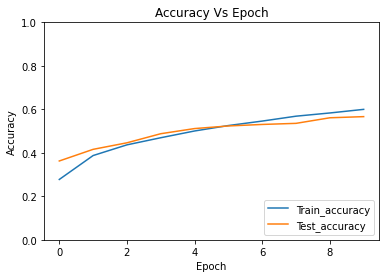

In [27]:
import matplotlib.pyplot as plt
plt.plot(vgg_model2.history['accuracy'], label='Train_accuracy')
plt.plot(vgg_model2.history['val_accuracy'], label = 'Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Vs Epoch")
plt.ylim([0, 1])
plt.legend(loc='lower right')

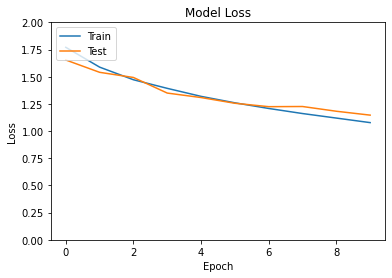

In [26]:
plt.plot(vgg_model2.history['loss'])
plt.plot(vgg_model2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,2)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
scores = model.evaluate(X_test, y_test)
(model.metrics_names[1], scores[1]*100)

113/113 [==============================] - 38s 335ms/step - loss: 1.1467 - accuracy: 0.5665


('accuracy', 56.64530396461487)